# __COVID-19 Data Analysis__

Abby Bechtel and Elmer Camargo  
CPSC392 Final Project

In [2]:
# imports
import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#reading zip code data and joining borough name
ny = pd.read_csv('data/ny18_cleaned.csv')
ny.head()

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,...,4_2_bb_beds,4_7_bb_beds,licensed_beds,staffed_beds,ICU_beds,adult_icu_beds,pediatrics_icu_beds,bed_utilization_rate,potential_increase_bed_capacity,avg_ventilator_use
0,10065,984654,0,28109,24285,86.4,619,2.2,37,0.1,...,7993,7993,6493,5519,745,745,402,6.647990,974,181
1,10069,249050,0,5085,3155,62.0,148,2.9,0,0.0,...,4922,4922,4093,3765,410,410,273,4.741397,328,138
2,10075,477137,0,21556,18396,85.3,677,3.1,225,1.0,...,7729,7729,6277,5678,788,788,412,7.253486,599,198
3,10128,1206191,0,59256,47167,79.6,2182,3.7,0,0.0,...,6233,6233,4713,4177,514,514,337,6.464822,536,147
4,10280,297253,38409,9384,7360,78.4,184,2.0,0,0.0,...,688,688,713,420,35,35,28,1.790607,293,12


In [4]:
boroughs_zip = pd.read_csv('data/bor_zip_codes.csv')
ny = pd.merge(ny,boroughs_zip[['GEOID10', 'borough']], left_on='GEOID_ZIP', right_on='GEOID10')
del(boroughs_zip)
ny.head()

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,...,licensed_beds,staffed_beds,ICU_beds,adult_icu_beds,pediatrics_icu_beds,bed_utilization_rate,potential_increase_bed_capacity,avg_ventilator_use,GEOID10,borough
0,10065,984654,0,28109,24285,86.4,619,2.2,37,0.1,...,6493,5519,745,745,402,6.647990,974,181,10065,Manhattan
1,10069,249050,0,5085,3155,62.0,148,2.9,0,0.0,...,4093,3765,410,410,273,4.741397,328,138,10069,Manhattan
2,10075,477137,0,21556,18396,85.3,677,3.1,225,1.0,...,6277,5678,788,788,412,7.253486,599,198,10075,Manhattan
3,10128,1206191,0,59256,47167,79.6,2182,3.7,0,0.0,...,4713,4177,514,514,337,6.464822,536,147,10128,Manhattan
4,10280,297253,38409,9384,7360,78.4,184,2.0,0,0.0,...,713,420,35,35,28,1.790607,293,12,10280,Manhattan


In [5]:
gm = pd.read_csv('data/Google_Mobility_Report_Filtered.csv')
gm.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,New York,Bronx,2/15/2020,0,-8,-5,-3,0,1
1,US,United States,New York,Bronx,2/16/2020,-1,-4,5,-2,-2,0
2,US,United States,New York,Bronx,2/17/2020,3,-8,-11,-22,-38,10
3,US,United States,New York,Bronx,2/18/2020,-2,-6,-11,-7,-10,3
4,US,United States,New York,Bronx,2/19/2020,2,-6,0,-6,-9,2


In [6]:
# using an aggregate of drop in baseline from "normal" starting from Feb 15 - Apr 11
# figured an aggregate would be best way to deal with the abundance of data
gm_agg = gm.groupby(['sub_region_2']).agg({col: ['sum'] for col in ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']})
gm_agg.columns = ['_'.join(multi_index) for multi_index in gm_agg.columns.ravel()]
gm_agg = gm_agg.reset_index()
gm_agg

,sub_region_2,retail_and_recreation_percent_change_from_baseline_sum,grocery_and_pharmacy_percent_change_from_baseline_sum,parks_percent_change_from_baseline_sum,transit_stations_percent_change_from_baseline_sum,workplaces_percent_change_from_baseline_sum,residential_percent_change_from_baseline_sum
0,Bronx,-1155,-211,-758,-1366,-1437,611
1,Brooklyn,-1407,-249,-45,-1677,-1601,715
2,Manhattan,-2296,-1006,-1544,-2199,-1926,777
3,Queens,-1470,-315,500,-1986,-1650,778
4,Staten Island,-1239,-254,-229,-1643,-1407,660


In [7]:
ny = pd.merge(ny, gm_agg, left_on='borough', right_on='sub_region_2')
ny.sample(10).head(10)

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,...,avg_ventilator_use,GEOID10,borough,sub_region_2,retail_and_recreation_percent_change_from_baseline_sum,grocery_and_pharmacy_percent_change_from_baseline_sum,parks_percent_change_from_baseline_sum,transit_stations_percent_change_from_baseline_sum,workplaces_percent_change_from_baseline_sum,residential_percent_change_from_baseline_sum
34,10033,1544119,0,59607,24141,40.5,6195,10.4,887,1.5,...,21,10033,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777
52,10309,17239616,102043,33531,30789,91.8,293,0.9,173,0.5,...,0,10309,Staten Island,Staten Island,-1239,-254,-229,-1643,-1407,660
78,10473,5539540,5538,59609,22362,37.5,24533,41.2,343,0.6,...,2,10473,Bronx,Bronx,-1155,-211,-758,-1366,-1437,611
88,11228,3813708,0,44994,25047,55.7,521,1.2,137,0.3,...,41,11228,Brooklyn,Brooklyn,-1407,-249,-45,-1677,-1601,715
69,10464,8993192,237116,4434,3495,78.8,119,2.7,0,0.0,...,0,10464,Bronx,Bronx,-1155,-211,-758,-1366,-1437,611
32,10031,1681546,0,60254,17917,29.7,17982,29.8,168,0.3,...,34,10031,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777
76,10471,6659943,28258,21896,15033,68.7,2583,11.8,38,0.2,...,45,10471,Bronx,Bronx,-1155,-211,-758,-1366,-1437,611
98,11239,1598723,27109,13244,4057,30.6,7991,60.3,137,1.0,...,19,11239,Brooklyn,Brooklyn,-1407,-249,-45,-1677,-1601,715
0,10065,984654,0,28109,24285,86.4,619,2.2,37,0.1,...,181,10065,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777
169,11420,5380501,0,48489,7399,15.3,11883,24.5,449,0.9,...,12,11420,Queens,Queens,-1470,-315,500,-1986,-1650,778


In [8]:
ny.describe()

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,...,bed_utilization_rate,potential_increase_bed_capacity,avg_ventilator_use,GEOID10,retail_and_recreation_percent_change_from_baseline_sum,grocery_and_pharmacy_percent_change_from_baseline_sum,parks_percent_change_from_baseline_sum,transit_stations_percent_change_from_baseline_sum,workplaces_percent_change_from_baseline_sum,residential_percent_change_from_baseline_sum
count,194.000000,1.940000e+02,1.940000e+02,194.000000,194.000000,194.000000,194.00000,194.000000,194.000000,194.000000,...,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,10828.551546,4.371207e+06,7.838591e+04,45262.613402,19373.520619,47.013402,11006.06701,21.694330,190.664948,0.368041,...,2.183867,222.860825,42.376289,10828.551546,-1584.597938,-440.494845,-295.056701,-1864.664948,-1656.886598,734.144330
std,565.862916,4.099438e+06,2.943986e+05,27080.485495,16227.159518,25.926974,15803.85357,24.727709,213.532651,0.338404,...,2.018925,339.896108,49.638566,565.862916,401.610583,309.308459,801.120868,279.167463,168.056053,61.992142
min,10001.000000,2.981200e+04,0.000000e+00,198.000000,25.000000,1.800000,0.00000,0.000000,0.000000,0.000000,...,0.000000,-579.000000,0.000000,10001.000000,-2296.000000,-1006.000000,-1544.000000,-2199.000000,-1926.000000,611.000000
25%,10304.250000,1.943517e+06,0.000000e+00,23567.500000,7090.250000,22.825000,1012.75000,3.125000,39.750000,0.100000,...,0.618909,0.000000,7.000000,10304.250000,-1470.000000,-315.000000,-758.000000,-1986.000000,-1650.000000,715.000000
50%,11102.500000,3.626872e+06,0.000000e+00,41235.500000,15160.500000,47.700000,3784.50000,9.700000,124.000000,0.300000,...,1.580388,117.000000,22.000000,11102.500000,-1470.000000,-315.000000,-45.000000,-1986.000000,-1650.000000,777.000000
75%,11360.750000,5.611287e+06,3.905400e+04,64477.000000,25929.000000,68.600000,14633.25000,32.275000,262.500000,0.600000,...,3.307185,460.750000,60.000000,11360.750000,-1407.000000,-249.000000,500.000000,-1677.000000,-1601.000000,778.000000
max,11697.000000,3.543250e+07,2.486438e+06,112425.000000,87155.000000,98.700000,86679.00000,92.600000,1311.000000,1.500000,...,7.253486,1055.000000,198.000000,11697.000000,-1155.000000,-211.000000,500.000000,-1366.000000,-1407.000000,778.000000


## Question 1: Do the socio-economic variables of a zip-code predict COVID cases?

**Visualization**

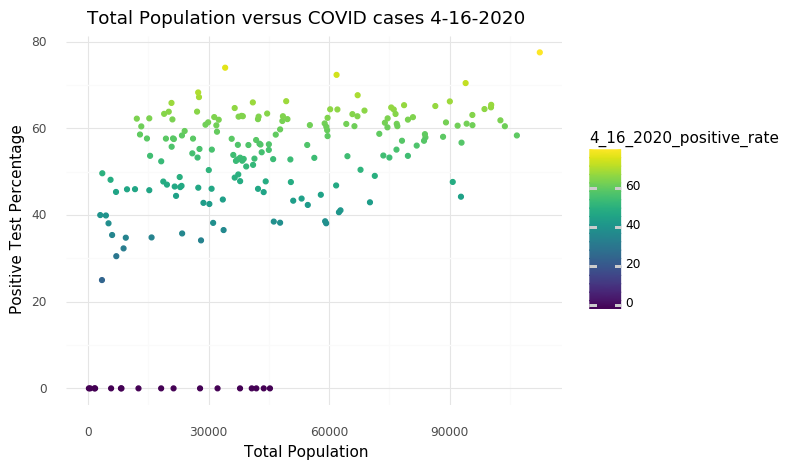

<ggplot: (7545332465)>

In [222]:
(ggplot(ny, aes(x='tot_pop', y='4_16_2020_positive_rate', color= '4_16_2020_positive_rate'))+ geom_point()+theme_minimal()+ ggtitle("Total Population versus COVID cases 4-16-2020")+ xlab("Total Population")+ylab("Positive Test Percentage"))

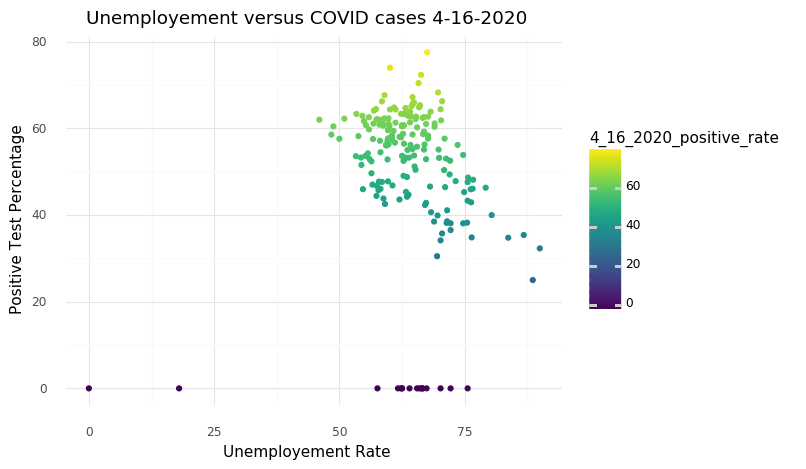

<ggplot: (7544485101)>

In [221]:
(ggplot(ny, aes(x='unemployment_rate', y='4_16_2020_positive_rate', color= '4_16_2020_positive_rate'))+ geom_point()+theme_minimal()+ ggtitle("Unemployement versus COVID cases 4-16-2020")+ xlab("Unemployement Rate")+ylab("Positive Test Percentage"))

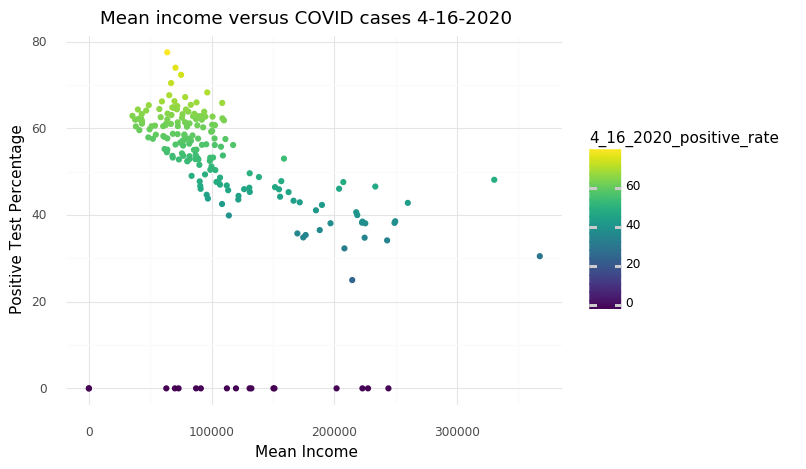

<ggplot: (7545663593)>

In [223]:
(ggplot(ny, aes(x='mean_incom', y='4_16_2020_positive_rate', color= '4_16_2020_positive_rate'))+ geom_point()+theme_minimal()+ ggtitle("Mean income versus COVID cases 4-16-2020")+ xlab("Mean Income")+ylab("Positive Test Percentage"))

**Factoring and minimizing to socio-economic variables**

In [224]:
ny.columns

Index(['GEOID_ZIP', 'ALAND10', 'AWATER10', 'tot_pop', 'white', 'per_white',
       'black', 'per_black', 'native', 'per_native',
       ...
       'avg_ventilator_use', 'GEOID10', 'borough', 'sub_region_2',
       'retail_and_recreation_percent_change_from_baseline_sum',
       'grocery_and_pharmacy_percent_change_from_baseline_sum',
       'parks_percent_change_from_baseline_sum',
       'transit_stations_percent_change_from_baseline_sum',
       'workplaces_percent_change_from_baseline_sum',
       'residential_percent_change_from_baseline_sum'],
      dtype='object', length=131)

In [9]:
df = ny[['GEOID_ZIP','ALAND10', 'tot_pop','disabled', 'per_disabled', 'unemployment_rate','tot_households_snap','households_snap','per_households_snap','tot_pop_mobility','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pop_pov','pop_below_','pcnt_pov','families_on_suplimental_income','families_on_social_security','insured','per_insured','uninsured','per_uninsured','owner','rent', '4_16_2020_positive_rate']].copy()

In [10]:
features = ['GEOID_ZIP','ALAND10', 'tot_pop','disabled', 'per_disabled', 'unemployment_rate','tot_households_snap','households_snap','per_households_snap','tot_pop_mobility','less_10k','10k_15k','15k_25k','25k_35k','35k_50k','50k_75k','75k_100k','100k_150k','150k_200k','more_200k','med_income','mean_incom','non_citizen','pop_pov','pop_below_','pcnt_pov','families_on_suplimental_income','families_on_social_security','insured','per_insured','uninsured','per_uninsured','owner','rent']

In [12]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)
kmo_model

0.87988679734785

In [13]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 5, rotation=None)
fa.fit(df[features])
loadings = fa.loadings_

# Check Eigenvalues
ev, v =  fa.get_eigenvalues()

AttributeError: 'FactorAnalyzer' object has no attribute 'factor_names'

In [14]:
xvals = range(1,df[features].shape[1]+1)

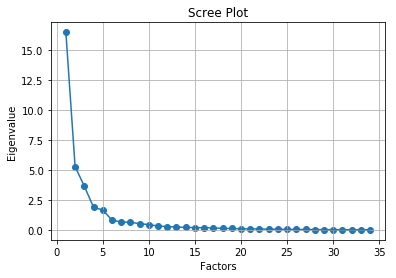

In [15]:
# Create scree plot using matplotlib
plt.scatter(xvals,ev)
plt.plot(xvals,ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [19]:
factors = pd.DataFrame.from_records(loadings)
factors

,0,1,2,3,4
0,0.097067,0.078808,-0.592642,-0.099941,-0.060551
1,0.074859,0.359269,-0.315216,0.334491,-0.249632
2,0.837583,0.537858,0.072479,-0.021543,-0.037413
3,0.897951,0.248416,0.152471,0.176253,-0.011892
4,0.374930,-0.351241,-0.092518,0.440644,0.011497
5,-0.319938,0.357052,0.276546,-0.287872,0.477788
6,0.732034,0.566515,0.242246,0.039045,-0.021581
7,0.910197,-0.037583,0.275412,0.040486,0.043591
8,0.828695,-0.405267,0.127036,0.083571,0.140462
9,0.837169,0.539138,0.070918,-0.021327,-0.037938


In [21]:
fa.get_factor_variance()

(array([16.32406791,  5.11798122,  3.37478912,  1.60212456,  1.40801957]),
 array([0.48011964, 0.15052886, 0.0992585 , 0.04712131, 0.04141234]),
 array([0.48011964, 0.6306485 , 0.72990701, 0.77702832, 0.81844066]))

In [25]:
fact = fa.transform(df[features])
fact = pd.DataFrame(fact)

model1 = LinearRegression()
model1.fit(df[features], df["4_16_2020_positive_rate"])
print("all data: ", model1.score(df[features], df["4_16_2020_positive_rate"]))

model2 = LinearRegression()
model2.fit(fact, df["4_16_2020_positive_rate"])
print("5 factors: ", model2.score(fact, df["4_16_2020_positive_rate"]))

all data:  0.5767774259331684
5 factors:  0.40333647963246344


,0,1,2,3,4
0,-2.426822,-3.423149,-0.217496,-1.864540,1.111115
1,-2.854028,-4.896987,-0.895320,-1.971061,1.615800
2,-0.499718,2.405342,1.200387,0.494831,-0.230757
3,-2.124378,-3.452355,-0.546400,-2.015614,1.613960
4,-1.469162,1.389099,2.030734,-0.710448,-0.168261
...,...,...,...,...,...
189,-1.432515,-4.282416,-2.083647,-1.663029,1.725427
190,1.199597,7.555433,1.388451,2.809514,-2.282990
191,-1.059368,0.914975,0.011713,0.468164,-0.084963
192,-0.872123,-1.705208,-0.348356,1.056652,-3.462398


In [218]:
# X = df[features]
# y = df["4_8_2020_positive_rate"]

# kf = KFold(n_splits = 5)
# model1 = LinearRegression()
# scores = []

# for train, test in kf.split(X,y):
#     X_train = X.iloc[train]
#     X_test = X.iloc[test]
#     y_train = y[train]
#     y_test = y[test]
#     model1.fit(X_train,y_train)
#     scores.append(model1.score(X_test,y_test))
    
    
# #print(scores)
# print(np.mean(scores))

-2.4019215090235773
